# Tutorial 05: Fast Bayesian inference for simulation-based inference

We will see how to perform fast Bayesian inference for simulation-based inference.<br>
We will carry out real-world task of parameter estimation on lithium-ion battery simulator:
- Bayesian inference for both posterior and evidence <a href="#section1">link</a>

## 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()

# need pandas and seaborn for visualisation
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')

<a id ="section1"></a>
## 1. Estimate both posterior and marginal likelihood (evidence)
Let's get started with the example of simulation-based inference.<br>
The simulation we use here is the equivalent circuit model (ECM), which models the responses of batteries at given operational conditions.<br>
We assume there is already the experimental result y_obs, and we wish to estimate the ECM parameters that reasonably reproduce the observation y_obs.<br>

We have three metrics to evaluate the fitness:
- error: $\text{error}(\theta) := \sum (y_\text{obs} - y_\text{pred}(\theta))^2$
- discrepancy: $d(\theta) := \log(\text{error}(\theta))$
- likelihood: $L(\theta) := \mathcal{N}(\text{error}(\theta); 0, \sigma^2)$

We use the discrepancy function for batch querying to find global optimum, whereas we use the likelihood function to estimate model evidece (marginal likelihood) for selection criterion.

The details of the model (equivalent circuit model)
- number of parameters: 6
- true ECM parameters = [2,-0.5,-1,0,0.5,1.0]
- bounds: (lower, upper) = ([1,-2,-2,-2, -2, 1], [3, 2, 2, 2, 2, 3])
- variable type: continuous
- optimisation: maximisation for discrepancy function

The parameters to estimate from left to right:
- resistance scale
- resistance of the first RC pair
- capacitance of the first RC pair
- resistance of the second RC pair
- capacitance of the second RC pair
- experimental noise variance

We can call prior and two functions with just one line of code.

In [2]:
from experiments._ecm import setup_ecm_two

prior, TestFunction = setup_ecm_two()

Let's visulalise the prior

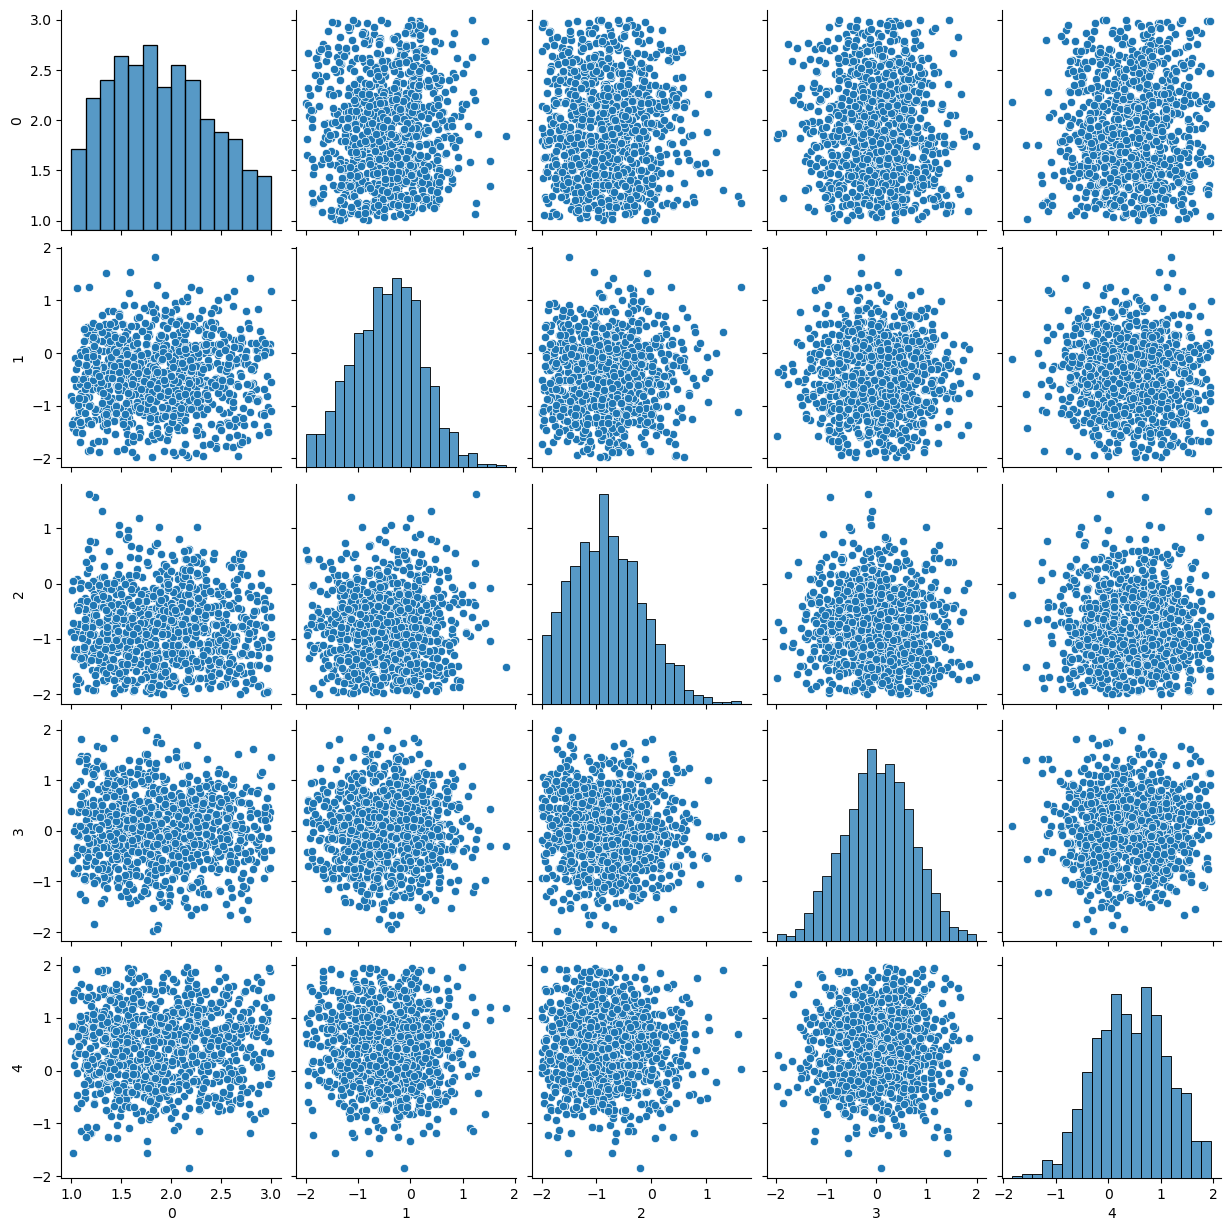

In [3]:
samples = prior.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

Visualise both discrepancy and likelihood

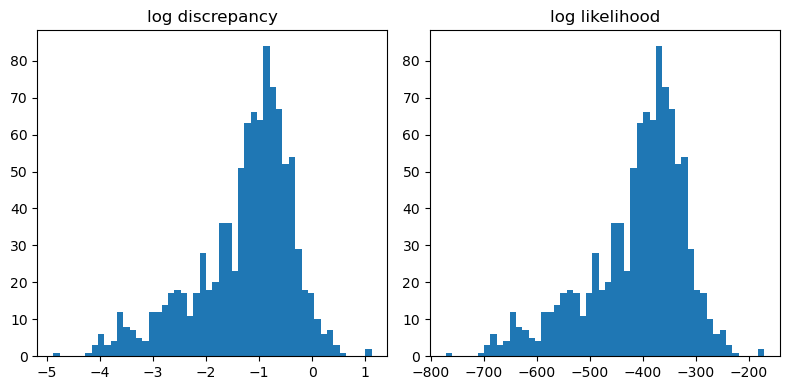

In [4]:
Ds, LLs = TestFunction(samples)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
ax[0].hist(tm.numpy(Ds), 50)
ax[0].set_title("log discrepancy")
ax[1].hist(tm.numpy(LLs), 50)
ax[1].set_title("log likelihood")
plt.show()

### 1.1 Define the GP model
We will define the acquisition function using a BoTorch library. <br>

In [5]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel with ARD.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel(ard_num_dims=X.shape[-1])
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-2, 10))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

def visualise_results(results, y_true=None):
    idx_batch = torch.arange(n_iterations)

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    ax[0].plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
    if not y_true == None:
        ax[0].axhline(y=y_true, linestyle="--", color="k", label="ground truth")
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")

    ax[1].plot(idx_batch, results[:,0], 'bo-')
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    plt.show()

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 1.2 Run SOBER for estimate parameters

In [6]:
seed = 0           # random seed
batch_size = 100   # number of batch samples
n_rec = 100000     # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 15  # number of iterations (batches)
obj = None         # acquisition function

true discrepancy: 2.64252e+00 true loglikelihood: -1.95359e+01 
200) Best discrepancy: 4.17848e-01 Best loglikelihood: -2.42003e+02 
Acquisition time [s]: 1.37943e+01, per sample [ms]: 1.37943e+02
300) Best discrepancy: 4.17848e-01 Best loglikelihood: -2.42003e+02 
Acquisition time [s]: 4.19972e+01, per sample [ms]: 4.19972e+02
400) Best discrepancy: 1.53784e+00 Best loglikelihood: -1.30003e+02 
Acquisition time [s]: 3.94442e+01, per sample [ms]: 3.94442e+02
500) Best discrepancy: 1.53784e+00 Best loglikelihood: -1.30003e+02 
Acquisition time [s]: 4.13495e+01, per sample [ms]: 4.13495e+02
600) Best discrepancy: 1.80064e+00 Best loglikelihood: -1.03723e+02 
Acquisition time [s]: 5.03512e+01, per sample [ms]: 5.03512e+02
700) Best discrepancy: 1.80064e+00 Best loglikelihood: -1.03723e+02 
Acquisition time [s]: 5.63462e+01, per sample [ms]: 5.63462e+02
800) Best discrepancy: 1.80064e+00 Best loglikelihood: -1.03723e+02 
Acquisition time [s]: 5.69437e+01, per sample [ms]: 5.69437e+02
The p

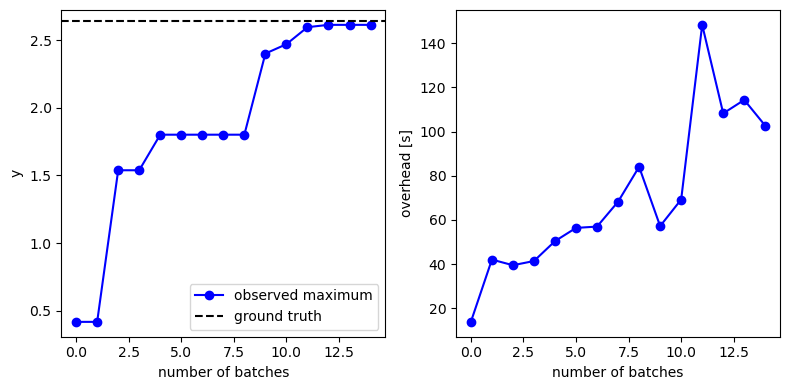

In [7]:
from SOBER._sober import Sober

torch.manual_seed(seed)  # random seed
params_true = tm.tensor([2, -0.5, -1, 0, 0.5]).unsqueeze(0)
d_true, L_true = TestFunction(params_true)
print(f"true discrepancy: {d_true.item():.5e} true loglikelihood: {L_true.item():.5e} ")

# initial sampling
Xall = prior.sample(n_init)
Yall, Lall = TestFunction(Xall)
model = set_rbf_model(Xall, Yall)
sober = Sober(prior, model)

results = []
for n_iter in range(1, n_iterations+1):
    start = time.monotonic()
    model = set_rbf_model(Xall, Yall)   # GP model with RBF kernel
    model = optimise_model(model)       # Optimise hyperparameters
    sober.update_model(model)           # pass the updated model to sober
    X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=obj,
        verbose=False,
    )
    end = time.monotonic()
    interval = end - start
    
    Y_batch, L_batch = TestFunction(X_batch)
    Xall = torch.cat((Xall, X_batch), dim=0)
    Yall = torch.cat((Yall, Y_batch), dim=0)
    Lall = torch.cat((Lall, L_batch), dim=0)

    print(f"{len(Xall)}) Best discrepancy: {Yall.max().item():.5e} Best loglikelihood: {Lall.max().item():.5e} ")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Yall.max().item()])

results = torch.tensor(results)
visualise_results(results, y_true=d_true)

### 1.3 Estimate Posterior and Evidence a posteriori

In [8]:
from SOBER.BASQ._scale_mmlt import ScaleMmltGP
from SOBER.BASQ._basq import BASQ

def set_BQ_model(Xall, Lall):
    base_kernel = RBFKernel(ard_num_dims=Xall.shape[-1])
    covar_module = ScaleKernel(base_kernel)
    model = ScaleMmltGP(Xall, Lall, covar_module)
    return model

Estimate evidence with uncertainty

In [27]:
n_quad = 20000
n_nys_quad = 500
n_res_quad = 500

model = set_BQ_model(Xall, Lall)
basq = BASQ(prior, model, sober)
ELML, AVLML = basq.quadrature(n_quad, n_nys_quad, n_res_quad) # estimate evidence

Expected log marginal likelihood: -2.74370e+01
Variance log marginal likelihood: -1.56464e+01


Visualise the estimated posterior distributions<br>
We can see the first parameter (scale parameter) has the smallest srd, meaning the most sensitive one.<br>
This makes sense as the scale is the most influential parameter to vary error.

In [28]:
n_posterior_samples = 1000
samples = basq.sampling_posterior(n_posterior_samples)
df = pd.DataFrame(samples.numpy())
print(params_true)
df.describe()

tensor([[ 2.0000, -0.5000, -1.0000,  0.0000,  0.5000]])


,0,1,2,3,4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.946790,0.031478,0.485333,-0.438236,-0.990164
std,0.059751,0.140664,0.083126,0.119511,0.078271
min,1.797365,-0.459667,0.287846,-0.866631,-1.249189
25%,1.902546,-0.062520,0.421438,-0.516308,-1.043672
50%,1.941915,0.024217,0.476036,-0.434770,-0.983535
75%,1.988286,0.130846,0.542843,-0.356123,-0.932621
max,2.163938,0.483525,0.750623,-0.129912,-0.812699


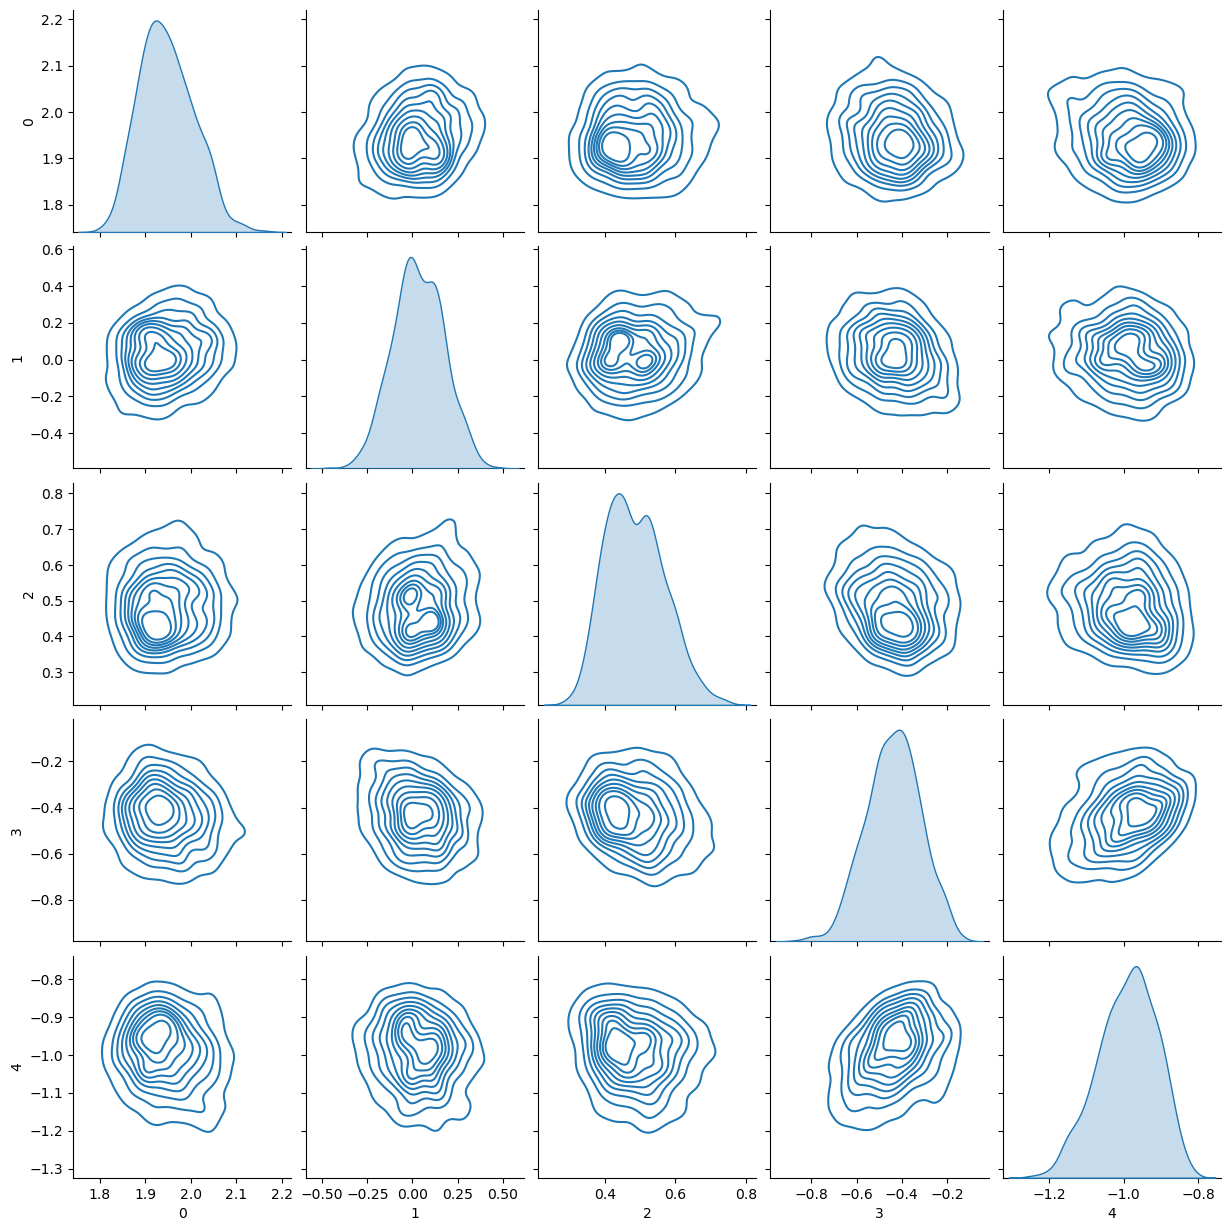

In [29]:
sns.pairplot(df, kind="kde")
plt.show()

Estimate MAP value of simulation parameters

In [46]:
MAP = basq.MAP(10000)
best_obs = Xall[Yall.argmax()]
print("Parameters, posterior, loglikelihood")
print(MAP, basq.posterior(MAP.unsqueeze(0)).detach(), TestFunction(MAP.unsqueeze(0))[1])
print(best_obs, basq.posterior(best_obs.unsqueeze(0)).detach(), TestFunction(best_obs.unsqueeze(0))[1])
print(params_true, basq.posterior(params_true).detach(), TestFunction(params_true)[1])

Parameters, posterior, loglikelihood
tensor([ 1.9600,  0.0509,  0.3568, -0.2651, -0.8680]) tensor([0.0020]) tensor([-168.2482])
tensor([ 1.9918,  0.0327,  0.5041, -0.4978, -1.0006]) tensor([0.0005]) tensor([-22.5832])
tensor([[ 2.0000, -0.5000, -1.0000,  0.0000,  0.5000]]) tensor([0.0018]) tensor([-19.5359])


The result may look different from the true parameters.<br>
However, this simulation has **two global optimum**.<br>
It is **exchangeable** between a set of 2nd and 3rd dimensions and one of 4th and 5th dimesions.<br>
Thus, it may look different but it captures one of two global optima.

## Remark
- Bayesian model selection

We can use the estimated evidence as the **model selection criterion**. When we have multiple plausible simulators, we can compare the evidence of each model fit to the data. Pick the model with the largest evidence is so-called Bayesian model selection.
See more details on https://arxiv.org/abs/2210.17299

- Bayesian model average

We can use the estimated evidence as the weights for the ensemble model. When multiple plausible simulators have indistinguishable evidence, we can use an ensemble model, which averages out the outputs from each model with weights. 